# Padding and masking layer in keras

Here a simple summary adn reasoning for the code.


1. Data Generation and Preprocessing:

Our model is designed to work with 2 to 4 features. The underlying function we're trying to approximate is:
```
f(x₁, x₂, x₃, x₄) = 2x₁² + 3x₂ - 1.5x₃ + 0.5x₄ + ε
````

Where `ε` is random noise $(N(0, 0.5²))$, and `x₃` and `x₄` may or may not be present.

2. Padding:

For inputs with fewer than 4 features, we pad with zeros:

```
[x₁, x₂] → [x₁, x₂, 0, 0]
[x₁, x₂, x₃] → [x₁, x₂, x₃, 0]
````

3. Normalization:

We normalize each feature independently:

```
x'ᵢ = (xᵢ - μᵢ) / σᵢ
````

Where μᵢ and σᵢ are the mean and standard deviation of the i-th feature.

4. Masking:

We create a binary mask M where:
Mᵢ = 1 if xᵢ is an actual feature
Mᵢ = 0 if xᵢ is a padded value (0)

5. Neural Network Architecture:

Our network consists of:
- Input layer (4 neurons)
- Masking layer
- Dense layer 1 (32 neurons, ReLU activation)
- Dense layer 2 (32 neurons, ReLU activation)
- Output layer (1 neuron, linear activation)

6. Forward Pass:

Let's denote the weight matrices as W¹, W², W³ and bias vectors as b¹, b², b³.

a) First, the masking layer zeros out the padded values:
x_masked = x'⊙ M  (where ⊙ is element-wise multiplication)

b) Then, for each dense layer:

```
h¹ = ReLU(W¹x_masked + b¹)
h² = ReLU(W²h¹ + b²)
y = W³h² + b³
````

Where ReLU(z) = max(0, z)

7. Loss Function:

We use Mean Squared Error (MSE):

$L = 1/n \sum_i(y_i - \hat{y}_i)^2$

Where y is the true (normalized) output and ŷ is the model's prediction.

## Reasoning

The key to handling variable features is the masking layer. It ensures that during both training and inference:
1. Padded values (zeros) don't contribute to the network's computations.
2. The network learns to ignore these padded values.
3. The same model can handle inputs with different numbers of features without changing its architecture.

This approach allows our single model to approximate the function for 2, 3, or 4 features without needing separate models or conditional logic in the network itself. The masking effectively "turns off" the parts of the network corresponding to missing features, allowing it to adapt to the input dimension dynamically.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Force TensorFlow to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

# Generate synthetic data with variable number of features
np.random.seed(0)

2024-07-11 09:57:43.137541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 09:57:43.137587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 09:57:43.138647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 09:57:43.145349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training device: CPU


2024-07-11 09:57:45.353651: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-11 09:57:45.353691: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: pcgpu-c2f07-18-01
2024-07-11 09:57:45.353698: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: pcgpu-c2f07-18-01
2024-07-11 09:57:45.353786: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-07-11 09:57:45.353808: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-07-11 09:57:45.353814: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


# Data Generation adn Padding

In [2]:
num_samples = 1000

def generate_sample(num_features):
    X = np.random.randn(num_features).astype(np.float32)
    y = (2 * X[0]**2 + 3 * X[1] + 
         (-1.5 * X[2] if num_features > 2 else 0) + 
         (0.5 * X[3] if num_features > 3 else 0) + 
         np.random.normal(0, 0.8)).astype(np.float32)
    return X, y

X = []
y = []

for _ in range(num_samples):
    num_features = np.random.choice([2, 3, 4])
    sample_X, sample_y = generate_sample(num_features)
    X.append(sample_X)
    y.append(sample_y)



# Padding 
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=4, padding='post', dtype='float32')
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Normalization
X_mean, X_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
y_mean, y_std = np.mean(y_train), np.std(y_train)

X_train_norm = (X_train - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std

# Create maks
mask_train = tf.not_equal(X_train, 0)
mask_val = tf.not_equal(X_val, 0)

In [3]:
print(X_train[:10])

[[-1.2910584  -1.0300188  -0.5174519   0.        ]
 [-0.23889631 -0.24901256  0.          0.        ]
 [ 0.11186542 -0.48113996  1.0440012   0.        ]
 [-2.9214175  -0.6843345   0.          0.        ]
 [-0.19856341 -2.4203782  -0.7165171  -1.1771753 ]
 [ 0.49079394  2.1587539   0.6734681   0.47978786]
 [ 0.5152652  -0.28143394  0.          0.        ]
 [-0.38951838  0.32478485  0.          0.        ]
 [ 0.58229244 -1.5496509   0.          0.        ]
 [-0.61827    -0.5904416  -0.59014416  0.        ]]


In [4]:
print(mask_train[:10])

tf.Tensor(
[[ True  True  True False]
 [ True  True False False]
 [ True  True  True False]
 [ True  True False False]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True False False]
 [ True  True False False]
 [ True  True False False]
 [ True  True  True False]], shape=(10, 4), dtype=bool)


## Model

In [5]:
class MaskedFunctionApproximator(keras.Model):
    def __init__(self):
        super(MaskedFunctionApproximator, self).__init__()
        self.masking = layers.Masking(mask_value=0., input_shape=(4,)) #here the important part
        self.dense1 = layers.Dense(32, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.dense3 = layers.Dense(1)
    
    def call(self, inputs):
        x = self.masking(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

In [6]:
# Instantiate the mode
model = MaskedFunctionApproximator()
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Custom training loop
@tf.function
def train_step(x, y, mask):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(x, y, mask):
    predictions = model(x, training=False)
    loss = loss_fn(y, predictions)
    return loss

### Training

Epoch 10, Loss: 0.0386, Val Loss: 0.0482
Epoch 20, Loss: 0.0347, Val Loss: 0.0419
Epoch 30, Loss: 0.0385, Val Loss: 0.0454
Epoch 40, Loss: 0.0378, Val Loss: 0.0457
Epoch 50, Loss: 0.0377, Val Loss: 0.0513
Epoch 60, Loss: 0.0353, Val Loss: 0.0472
Epoch 70, Loss: 0.0311, Val Loss: 0.0464
Epoch 80, Loss: 0.0356, Val Loss: 0.0516
Epoch 90, Loss: 0.0278, Val Loss: 0.0496
Epoch 100, Loss: 0.0292, Val Loss: 0.0499
Epoch 110, Loss: 0.0276, Val Loss: 0.0569
Epoch 120, Loss: 0.0278, Val Loss: 0.0511
Epoch 130, Loss: 0.0253, Val Loss: 0.0477
Epoch 140, Loss: 0.0301, Val Loss: 0.0591
Epoch 150, Loss: 0.0315, Val Loss: 0.0592
Epoch 160, Loss: 0.0300, Val Loss: 0.0541
Epoch 170, Loss: 0.0273, Val Loss: 0.0608
Epoch 180, Loss: 0.0233, Val Loss: 0.0541
Epoch 190, Loss: 0.0268, Val Loss: 0.0621
Epoch 200, Loss: 0.0275, Val Loss: 0.0698


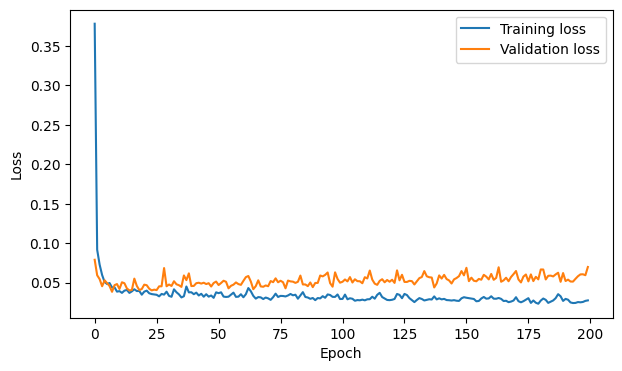

In [7]:
# Training
epochs = 200
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_norm.reshape(-1, 1), mask_train)).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_norm.reshape(-1, 1), mask_val)).batch(batch_size)

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_train_losses = []
    epoch_val_losses = []
    
    for x_batch, y_batch, mask_batch in train_dataset:
        train_loss = train_step(x_batch, y_batch, mask_batch)
        epoch_train_losses.append(train_loss)
    
    for x_val_batch, y_val_batch, mask_val_batch in val_dataset:
        val_loss = val_step(x_val_batch, y_val_batch, mask_val_batch)
        epoch_val_losses.append(val_loss)
    
    train_losses.append(tf.reduce_mean(epoch_train_losses))
    val_losses.append(tf.reduce_mean(epoch_val_losses))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_losses[-1].numpy():.4f}, Val Loss: {val_losses[-1].numpy():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 0s 1ms/step


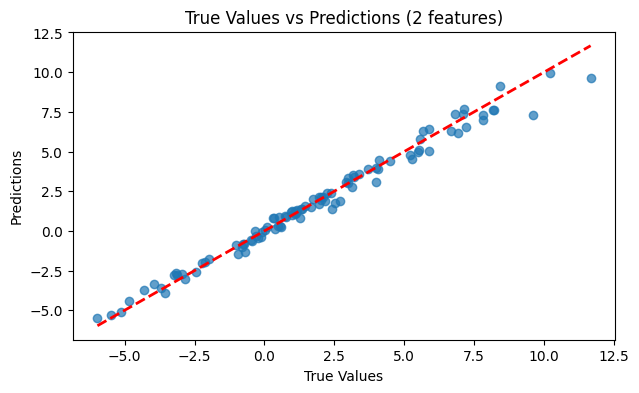

4/4 [==============================] - 0s 1ms/step


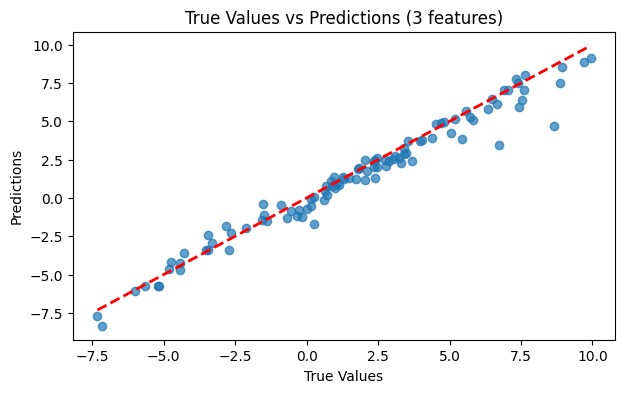

4/4 [==============================] - 0s 1ms/step


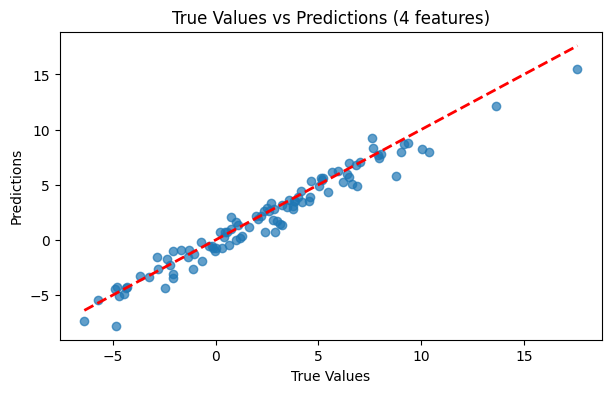

1/1 [==============================] - 0s 21ms/step

Prediction for 2 features:
Input X = [-0.7853214 -2.1645515]
Predicted y: -5.28
True y: -5.26
1/1 [==============================] - 0s 22ms/step

Prediction for 3 features:
Input X = [ 1.1445812 -0.9505018  0.7641232]
Predicted y: -1.04
True y: -1.38
1/1 [==============================] - 0s 20ms/step

Prediction for 4 features:
Input X = [ 1.3194897  -0.12032467 -1.0543095  -2.7589276 ]
Predicted y: 4.36
True y: 3.32


In [8]:
def prepare_test_data(num_features):
    X_test = np.random.randn(100, num_features).astype(np.float32)
    y_test = np.zeros(100, dtype=np.float32)
    
    y_test += 2 * X_test[:, 0]**2
    y_test += 3 * X_test[:, 1]
    if num_features > 2:
        y_test += -1.5 * X_test[:, 2]
    if num_features > 3:
        y_test += 0.5 * X_test[:, 3]
    
    X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=4, padding='post', dtype='float32')
    X_test_norm = (X_test_padded - X_mean) / X_std
    
    return X_test_norm, y_test

# Test for 2, 3, and 4 features
for num_features in [2, 3, 4]:
    X_test_norm, y_true = prepare_test_data(num_features)
    y_pred_norm = model.predict(X_test_norm)
    y_pred = y_pred_norm * y_std + y_mean

    plt.figure(figsize=(7, 4))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'True Values vs Predictions ({num_features} features)')
    plt.show()

# Make predictions
for num_features in [2, 3, 4]:
    new_X = np.random.randn(1, num_features).astype(np.float32)
    new_X_padded = tf.keras.preprocessing.sequence.pad_sequences(new_X, maxlen=4, padding='post', dtype='float32')
    new_X_norm = (new_X_padded - X_mean) / X_std
    predicted_y_norm = model.predict(new_X_norm)
    predicted_y = predicted_y_norm * y_std + y_mean

    print(f"\nPrediction for {num_features} features:")
    print(f"Input X = {new_X[0]}")
    print(f"Predicted y: {predicted_y[0][0]:.2f}")
    true_y = (2 * new_X[0, 0]**2 + 3 * new_X[0, 1] + 
              (-1.5 * new_X[0, 2] if num_features > 2 else 0) + 
              (0.5 * new_X[0, 3] if num_features > 3 else 0))
    print(f"True y: {true_y:.2f}")